<a href="https://colab.research.google.com/github/sparks-baird/xtal2png/blob/main/notebooks/3.1-imagen-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using `xtal2png` with `imagen-pytorch`

In [1]:
!nvidia-smi

Sat Oct  8 06:26:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
dummy = False #@param {type:"boolean"}

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%pip install mp-time-split xtal2png matbench-genmetrics imagen-pytorch==1.11.4

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 708 kB 10.3 MB/s 
     |████████████████████████████████| 314 kB 75.9 MB/s 
     |████████████████████████████████| 565 kB 62.1 MB/s 
     |████████████████████████████████| 4.9 MB 78.0 MB/s 
     |████████████████████████████████| 148 kB 79.4 MB/s 
     |████████████████████████████████| 1.3 MB 73.2 MB/s 
     |████████████████████████████████| 561 kB 75.4 MB/s 
     |████████████████████████████████| 1.4 MB 74.7 MB/s 
     |████████████████████████████████| 40.6 MB 1.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 73.2 MB/s 
     |████████████████████████████████| 79.9 MB 1.1 MB/s 
     |██████

In [4]:
try:
  from google.colab import output
  output.enable_custom_widget_manager()
except Exception as e:
  print(e)
  pass

In [5]:
from os import path
from pathlib import Path
from uuid import uuid4
from tqdm import tqdm
import math

import numpy as np
import torch
from imagen_pytorch import ImagenConfig, ElucidatedImagenConfig, ImagenTrainer
from matbench_genmetrics.core import MPTSMetrics10, MPTSMetrics1000

from xtal2png.core import XtalConverter

Downloading:   0%|          | 0.00/605 [00:00<?, ?B/s]

## Helper

In [6]:
from PIL import Image
def image_grid(imgs, rows, cols):
    """https://stackoverflow.com/questions/37921295/python-pil-image-make-3x3-grid-from-sequence-images
    https://stackoverflow.com/a/65583584/13697228
    """
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [7]:
import gc
from torch.cuda import empty_cache

def deallocate():
  if "trainer" in locals():
    try:
      del trainer
    except Exception as e:
      print(e)
      pass
  if "imagen" in locals():
    try:
      del imagen
    except Exception as e:
      print(e)
      pass
  if "training_images" in locals():
    try:
      del training_images
    except Exception as e:
      print(e)
      pass

  gc.collect()
  empty_cache()

## Data and `xtal2png` images

In [8]:
if dummy:
  mptm = MPTSMetrics10(dummy=dummy, verbose=True)
else:
  mptm = MPTSMetrics1000(dummy=dummy, verbose=True)

fold = 0
train_val_inputs = mptm.get_train_and_val_data(fold)

xc = XtalConverter(encode_cell_type=None, decode_cell_type=None)
arrays, id_data, id_mapper = xc.structures_to_arrays(train_val_inputs.tolist(), rgb_scaling=False)

Reading file /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_time_summary.json.gz: 0it [01:21, ?it/s]
Decoding objects from /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_time_summary.json.gz: 100%|##########| 40476/40476 [01:21<00:00, 497.36it/s]
100%|██████████| 5400/5400 [01:23<00:00, 65.02it/s]


In [9]:
gdrive_dir = '/content/drive/MyDrive/sparks-baird/xtal2png/'
print(path.isdir(gdrive_dir))
if dummy:
  gdrive_dir = path.join(gdrive_dir, "dummy")

True


## Training

In [14]:
if dummy:
  dummy_timesteps = 10 #@param {type:"integer"}
  dummy_epochs = 3 #@param {type:"integer"}
  dummy_checkpoint_rate = 2 #@param {type:"integer"}
  dummy_max_batch_size = 1 #@param {type:"integer"}
  dummy_dim = 16 #@param {type:"integer"}
  timesteps = dummy_timesteps
  epochs = dummy_epochs
  checkpoint_rate = dummy_checkpoint_rate
  max_batch_size = dummy_max_batch_size
  dim = dummy_dim
else:
  timesteps = 1000 #@param {type:"integer"}
  epochs = 1000 #@param {type:"integer"}
  checkpoint_rate = 100 #@param {type:"integer"}
  # max_batch_size suggested by lucidrains to be at least 32
  max_batch_size = 64 #@param {type:"integer"}
  dim = 128 #@param {type:"integer"}

In [15]:
results_folder = path.join(
    gdrive_dir,
    "data",
    "interim",
    "elucidated-imagen-pytorch",
    f"fold={fold}",
    # str(uuid4())[0:4],
)

checkpoint_folder = path.join(results_folder, "checkpoint")
Path(checkpoint_folder).mkdir(exist_ok=True, parents=True)

In [16]:
from glob import glob

files = glob(path.join(checkpoint_folder, "epoch=*.pt"))
checkpoint_epochs = [int(Path(file).stem.split("epoch=")[-1]) for file in files]
latest_chkpt_num = max(checkpoint_epochs) if len(checkpoint_epochs) > 0 else 0
latest_chkpt_num

0

In [17]:
from imagen_pytorch import load_imagen_from_checkpoint, ImagenTrainer

deallocate() # free up CUDA memory of previously defined `imagen` and `trainer` if existing

training_images = torch.from_numpy(arrays).float().cuda()

if latest_chkpt_num != 0:
  latest_checkpoint = path.join(checkpoint_folder, f"epoch={latest_chkpt_num}.pt")
  imagen = load_imagen_from_checkpoint(latest_checkpoint)
else:
  imagen = ElucidatedImagenConfig(
      condition_on_text=False,
      unets = [
          dict(dim = dim, dim_mults = (1, 2, 4, 8), memory_efficient=True),
          dict(dim = dim, dim_mults = (1, 2, 4, 8), memory_efficient=True),
      ],
      image_sizes = (32, 64),
      channels=1,
      cond_drop_prob = 0.1,
      num_sample_steps = 32,       # number of sample steps (default)
      sigma_min = 0.002,           # min noise level (default)
      sigma_max = 80,              # max noise level (default)
      sigma_data = 0.5,            # standard deviation of data distribution (default)
      rho = 7,                     # controls the sampling schedule (default)
      P_mean = -1.2,               # mean of log-normal distribution from which noise is drawn for training (default)
      P_std = 1.2,                 # standard deviation of log-normal distribution from which noise is drawn for training (default)
      S_churn = 80,                # parameters for stochastic sampling - depends on dataset, Table 5 in apper (default)
      S_tmin = 0.05,
      S_tmax = 50,
      S_noise = 1.003,
      # timesteps = timesteps, # Imagen
  ).create()

trainer = ImagenTrainer(imagen)

In [18]:
%%capture nvidia_smi_output_instantiated
!nvidia-smi

In [27]:
tmppath = path.join(results_folder, f"nvidia-smi-instantiated-checkpoint-{latest_chkpt_num}.txt")
with open(tmppath, "w") as f:
  f.write(nvidia_smi_output_instantiated.stdout)

In [29]:
!nvidia-smi

Sat Oct  8 06:42:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    48W / 400W |   4456MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  0%|          | 1/1000 [02:03<34:10:41, 123.16s/it]

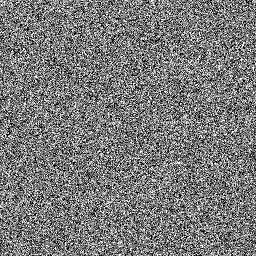

this checkpoint is commandable from the CLI - "imagen --model /content/drive/MyDrive/sparks-baird/xtal2png/data/interim/elucidated-imagen-pytorch/fold=0/checkpoint/epoch=0.pt "<prompt>""
checkpoint saved to /content/drive/MyDrive/sparks-baird/xtal2png/data/interim/elucidated-imagen-pytorch/fold=0/checkpoint/epoch=0.pt
loss is 1.953648234717548 for epoch=0


 10%|█         | 101/1000 [3:15:41<28:56:07, 115.87s/it]

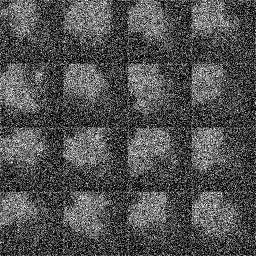

this checkpoint is commandable from the CLI - "imagen --model /content/drive/MyDrive/sparks-baird/xtal2png/data/interim/elucidated-imagen-pytorch/fold=0/checkpoint/epoch=100.pt "<prompt>""
checkpoint saved to /content/drive/MyDrive/sparks-baird/xtal2png/data/interim/elucidated-imagen-pytorch/fold=0/checkpoint/epoch=100.pt
loss is 0.8361775362864137 for epoch=100


 20%|██        | 201/1000 [6:30:17<25:56:53, 116.91s/it]

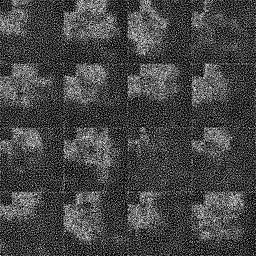

this checkpoint is commandable from the CLI - "imagen --model /content/drive/MyDrive/sparks-baird/xtal2png/data/interim/elucidated-imagen-pytorch/fold=0/checkpoint/epoch=200.pt "<prompt>""
checkpoint saved to /content/drive/MyDrive/sparks-baird/xtal2png/data/interim/elucidated-imagen-pytorch/fold=0/checkpoint/epoch=200.pt
loss is 0.6849522094707936 for epoch=200


 30%|███       | 301/1000 [9:46:09<22:52:13, 117.79s/it]

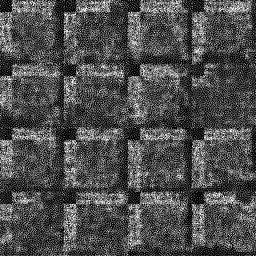

this checkpoint is commandable from the CLI - "imagen --model /content/drive/MyDrive/sparks-baird/xtal2png/data/interim/elucidated-imagen-pytorch/fold=0/checkpoint/epoch=300.pt "<prompt>""
checkpoint saved to /content/drive/MyDrive/sparks-baird/xtal2png/data/interim/elucidated-imagen-pytorch/fold=0/checkpoint/epoch=300.pt
loss is 0.51092101004906 for epoch=300


 35%|███▍      | 348/1000 [11:18:19<21:06:12, 116.52s/it]

In [ ]:
# capture the tqdm output (which keeps printing newlines) to avoid Colab crash
from IPython.utils import io
import pandas as pd

# train each unet in concert, or separately (recommended) to completion
l_arr = [[],[]]

with tqdm(initial=latest_chkpt_num, total=epochs) as pbar:
  for epoch in range(latest_chkpt_num, epochs):
    for u in (1, 2):
      with io.capture_output() as captured:
        loss = trainer(training_images, unet_number=u, max_batch_size=max_batch_size)
        trainer.update(unet_number=u)
        trainer.save('./checkpoint.pt') # for switching back-and-forth b/t unets
        imagen = load_imagen_from_checkpoint('./checkpoint.pt')
        trainer = ImagenTrainer(imagen)
      l_arr[u-1].append(loss)
    pbar.update()
    if (epoch % checkpoint_rate == 0) or (epoch == epochs - 1):
      with io.capture_output() as captured:
        images = trainer.sample(batch_size=16, return_pil_images=True)

      grid = image_grid(images, 4, 4)
      display(grid)
      grid.save(path.join(checkpoint_folder, f"sample_4x4,epoch={epoch}.png"))
      # if not math.isnan(loss) and (epoch != epochs - 1):
      trainer.save(path.join(checkpoint_folder, f"epoch={epoch}.pt"))
      pd.DataFrame(dict(u1=l_arr[0], u2=l_arr[1])).to_csv(path.join(checkpoint_folder, f"loss_epoch={epoch}.csv"), index=False)
      print(f"loss is {loss} for epoch={epoch}")

## Sampling

In [ ]:
with io.capture_output() as captured:
  images = trainer.sample(batch_size=16, return_pil_images=True)
  trainer.save(path.join(results_folder, f"epoch={epoch}.pt"))

In [ ]:
grid = image_grid(images, 4, 4)
display(grid)
grid.save(path.join(results_folder, f"sample_4x4,epoch={epoch}.png"))

## deallocate CUDA memory
https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28

In [ ]:
%%capture nvidia_smi_output
!nvidia-smi

In [ ]:
tmppath = path.join(results_folder, f"nvidia-smi-completed-checkpoint-{latest_chkpt_num}.txt")
with open(tmppath, "w") as f:
  f.write(nvidia_smi_output.stdout)

In [ ]:
deallocate()
!nvidia-smi

In [ ]:
num_gen = mptm.num_gen

if dummy:
  n = 1
else:
  n = 100

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

gen_images = []

with io.capture_output() as captured:
  for chunk in tqdm(chunks(range(num_gen), n)):
    gen_images.append(trainer.sample(batch_size=len(chunk), return_pil_images=True))

In [ ]:
gen_structures = xc.png2xtal(gen_images)
mptm.evaluate_and_record(fold, gen_structures)
print(mptm.recorded_metrics)

In [ ]:
import json
import pickle
with open(path.join(results_folder, f"metrics_epoch={epoch}.json"),"w") as f:
    json.dump(mptm.recorded_metrics,f)

with open(path.join(results_folder, f"mptm_epoch={epoch}.pkl"), "wb") as f:
  pickle.dump(mptm, f)

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();')) # save and pin revision, check

In [ ]:
import time

timestr = time.strftime("%Y%m%d-%H%M%S")
notebook_savepath = path.join(results_folder, f"notebook-{timestr}.ipynb")
print(notebook_savepath)

In [ ]:
# doesn't save output
%notebook -e notebook.ipynb
!mv notebook.ipynb $notebook_savepath

In [ ]:
from google.colab import runtime
runtime.unassign()

## Code Graveyard

In [ ]:
# %pip install  ase nglview ipywidgets python-vtk

# import crystal_toolkit.components as ctc
# from ase.io import write
# from pymatgen.io.ase import AseAtomsAdaptor
# from pymatgen.vis.structure_vtk import StructureVis
# from PIL import Image

# def get_pil_image(atoms):
#   fname = 'image.png'
#   write(fname, gen_atoms[0])
#   return Image.open(fname)

# aaa = AseAtomsAdaptor()
# sv = StructureVis()

# def get_pil_from_struct(structure):
#   fname = 'image.png'
#   sv.set_structure(structure)
#   sv.write_image(fname)
#   return Image.open(fname)

        # arrs = np.expand_dims(np.stack([np.asarray(im) for im in images]), 1)
        # gen_structures = xc.png2xtal(images)
        # gen_atoms = [aaa.get_atoms(s) for s in gen_structures]
        # gen_views = [get_pil_image(ga) for ga in gen_atoms]
        # gen_views = [get_pil_from_struct(s) for s in gen_structures]

      # views_grid = image_grid(gen_views, 4, 4)
      # display(views_grid)
      # views_grid.save(path.join(checkpoint_folder, f"xtal_sample_4x4,epoch={epoch}.png"))

# gen_structs = xc.png2xtal(images)
# gen_atoms = [aaa.get_atoms(s) for s in gen_structures]
# gen_views = [get_pil_image(ga) for ga in gen_atoms]

In [ ]:
# gen_arrays = torch.concat(gen_subarrays, axis=0)
# gen_structures = xc.arrays_to_structures(gen_arrays.cpu().numpy(), id_data=id_data, id_mapper=id_mapper, rgb_scaling=False)